In [178]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

%matplotlib inline

%qtconsole

In [159]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [160]:
df = pd.read_csv(data_processed_dir+'processed_data.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True)
df = df[df.date > '2016-06'].reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2016-06-03,325.0,31.322,36.822,49.000,48.905,7.1945,7.216,1196.948,8.248,...,36.893488,32.772432,1.041334,60.121197,36.822,46.583235,36.822,49.971020,36.822,96.554255
1,2016-06-10,328.0,34.434,36.720,50.184,49.944,7.1560,7.133,1196.015,8.224,...,36.940973,32.761824,1.011001,60.325617,36.720,46.580276,36.720,49.813063,36.720,96.393339


In [161]:
# Remove wti_spot, brent_spot for redundant values with wti_spot_lag_14
df = df.drop(['wti_spot','brent_spot'],axis=1)

# Noticed significant variation in early models that were not present in the majority of the data. 
# SelectKBest ended up adding much more significance to the world_cons data and caused modeling
# issues with MinMaxScaler... Same issues existed with StandardScaler
df = df.drop(['world_cons','oecd_cons','non-oecd_cons','usa_net_import','usa_l48_prod'],axis=1)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,usa_net_import_smooth,usa_stocks_all,usa_l48_prod_smooth,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,non-oecd_cons_smooth,world_cons_smooth
0,2016-06-03,325.0,31.322,36.822,7.1945,1196.948,8.248,36.893488,32.772432,1.041334,60.121197,36.822,36.822,36.822
1,2016-06-10,328.0,34.434,36.720,7.1560,1196.015,8.224,36.940973,32.761824,1.011001,60.325617,36.720,36.720,36.720


In [162]:
df.shape

(222, 14)

## Train Test Split
Define features X, and target variable y

In [163]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

#scaler = MinMaxScaler()
#scaler.fit(df.iloc[:,1:])
#X = scaler.transform(df.iloc[:,1:])
#X = pd.DataFrame(X,columns=df.iloc[:,1:].columns)
#X[['Total US RigCount','wti_spot_lag_14']].plot(figsize=(12,10))

In [164]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe,plot=True):

    mse = []
    r2 = []
    mae = []
    
    if plot == True:
        fig, ax = plt.subplots(figsize=(18,10))
        ax.plot(date,y)
        ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        plt.xticks(rotation=75)

        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            y_pred = pipe.predict(X_tt)

            mse.append(mean_squared_error(y_pred,y_tt,squared=False))
            r2.append(r2_score(y_pred,y_tt))
            mae.append(mean_absolute_error(y_pred,y_tt))

            ax.plot(date[tt],y_pred, label='test iter no '+str(ii+1))
        
        plt.legend()
        plt.show()

    else:
        
        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            y_pred = pipe.predict(X_tt)

            mse.append(mean_squared_error(y_pred,y_tt,squared=False))
            r2.append(r2_score(y_pred,y_tt))
            mae.append(mean_absolute_error(y_pred,y_tt))
            
    return np.mean(mse), np.mean(r2), np.mean(mae)

### Linear Regression 
Baseline model will be a linear regression with all features.

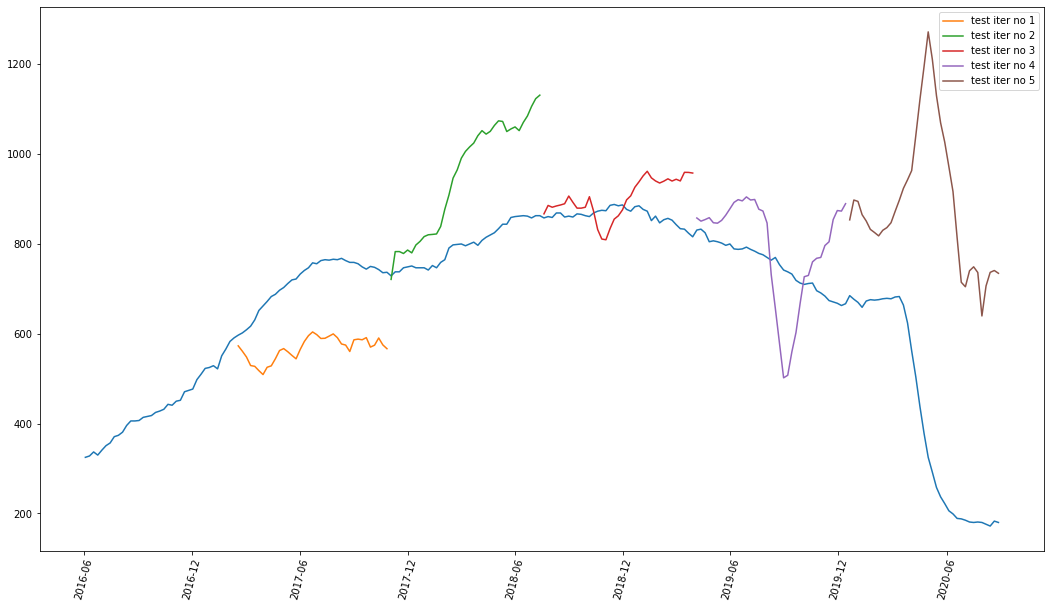

(209.5212567327324, -10.071910475167199, 185.23964261905203)

In [165]:
# Baseline linear regression with no additional features
n_splits = 5

model = LinearRegression()
cv = TimeSeriesSplit(n_splits=n_splits)
pipe = make_pipeline(model)

plot_model(date,X,y,cv,pipe)

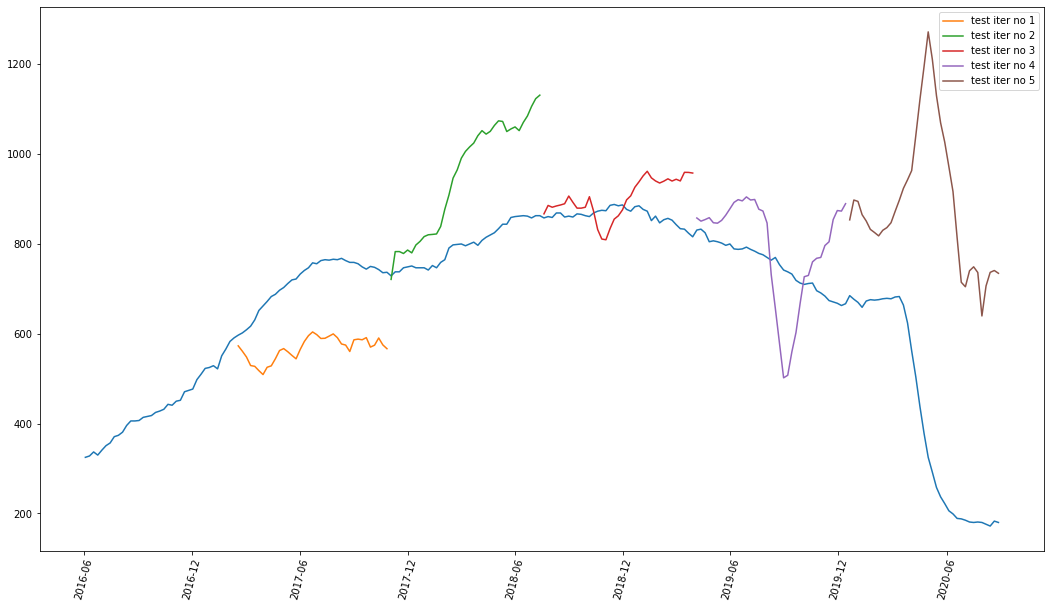

(209.52125673273127, -10.071910475165906, 185.2396426190508)

In [166]:
# Add scaler to features
scaler = StandardScaler()
pipe = make_pipeline(scaler,model)

plot_model(date,X,y,cv,pipe)

In [167]:
# Let's try with rolling window for the time series to account for the data being non-stationary

max_train_score = pd.DataFrame(columns=['rmse','r2','mae'])

for i in np.arange(1,df.shape[0]):
    cv = TimeSeriesSplit(n_splits=n_splits,max_train_size=i)

    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    max_train_score.loc[i,'rmse'] = mse
    max_train_score.loc[i,'r2'] = r2
    max_train_score.loc[i,'mae'] = mae
    
max_train_score.sort_values(by='rmse', inplace=True)
max_train_score.head()

,rmse,r2,mae
4,122.371,-6.23319,100.485
1,128.124,0,103.2
112,131.099,-9.3283,110.314
111,131.337,-9.90369,110.067
113,131.415,-8.92551,110.905


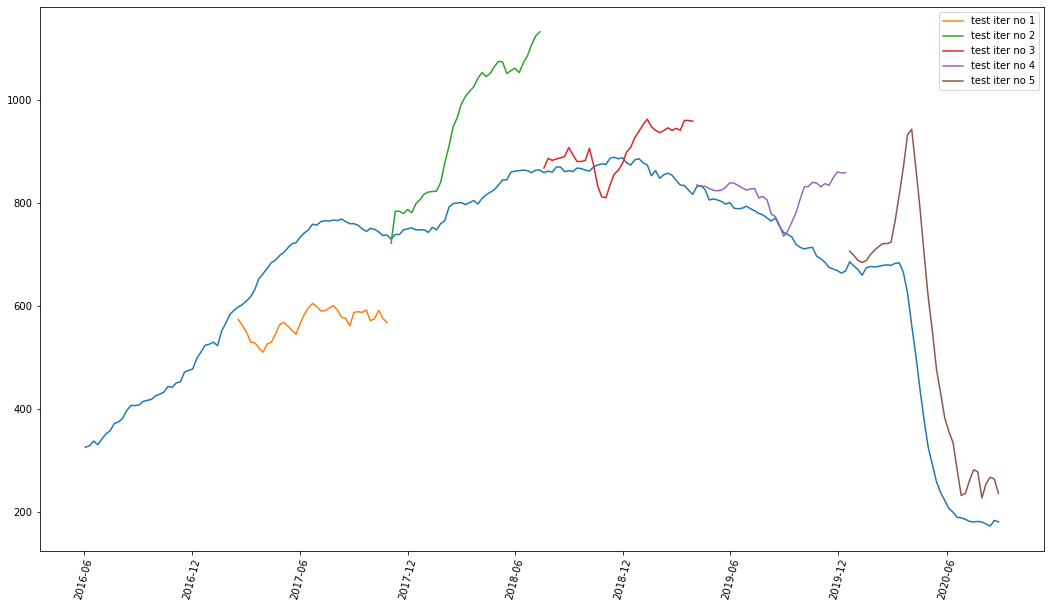

In [168]:
# Use 112 as the others are too small
max_train_best = max_train_score.index[2]

cv = TimeSeriesSplit(n_splits=n_splits,max_train_size=max_train_best)

mse, r2, mae = plot_model(date,X,y,cv,pipe)

In [169]:
# Parameter tuning for SelectKBest - manual
k_score = pd.DataFrame(columns=['rmse','r2','mae'])

for i in np.arange(1,len(X.columns)+1):
    feat_sel = SelectKBest(f_regression,k=i)
    pipe = make_pipeline(scaler,feat_sel,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    k_score.loc[i,'rmse'] = mse
    k_score.loc[i,'r2'] = r2
    k_score.loc[i,'mae'] = mae

k_score.sort_values(by='rmse',inplace=True)
k_score.head()

,rmse,r2,mae
12,131.099,-9.3283,110.314
11,136.38,-17.1932,116.935
10,159.412,-8.62964,131.763
9,163.135,-6.47663,135.13
3,173.397,-16.6218,155.98


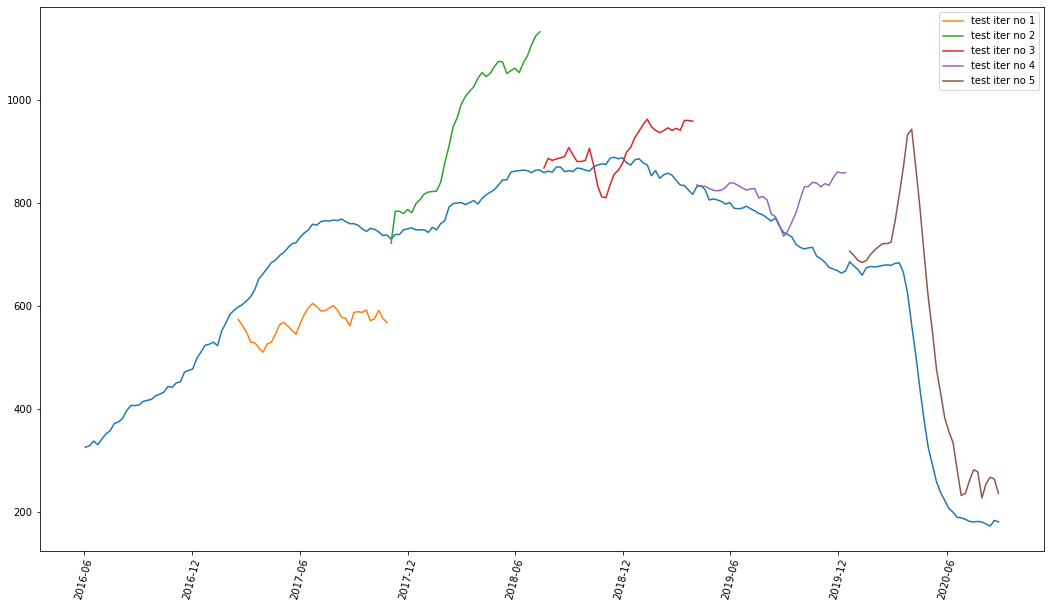

k is 12
rmse    131.099
r2      -9.3283
mae     110.314
Name: 12, dtype: object


In [170]:
k_best = k_score.index[0]

feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)
plot_model(date,X,y,cv,pipe)

print('k is '+str(k_best))
print(k_score.loc[k_best,:])

In [171]:
pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False)

opec_tot_prod            160.620105
usa_l48_prod_smooth       98.545937
opec_surp_capac           37.832664
wti_spot_lag_14           22.333334
usa_net_import_smooth     13.912977
usa_stocks_all            10.791704
world_cons_smooth          1.821268
non-oecd_cons_smooth       1.821268
oecd_cons_smooth           1.821268
wti_spot_lag_9             1.821268
non-opec_tot_prod        -69.997010
opec_crud_capac         -101.641408
dtype: float64

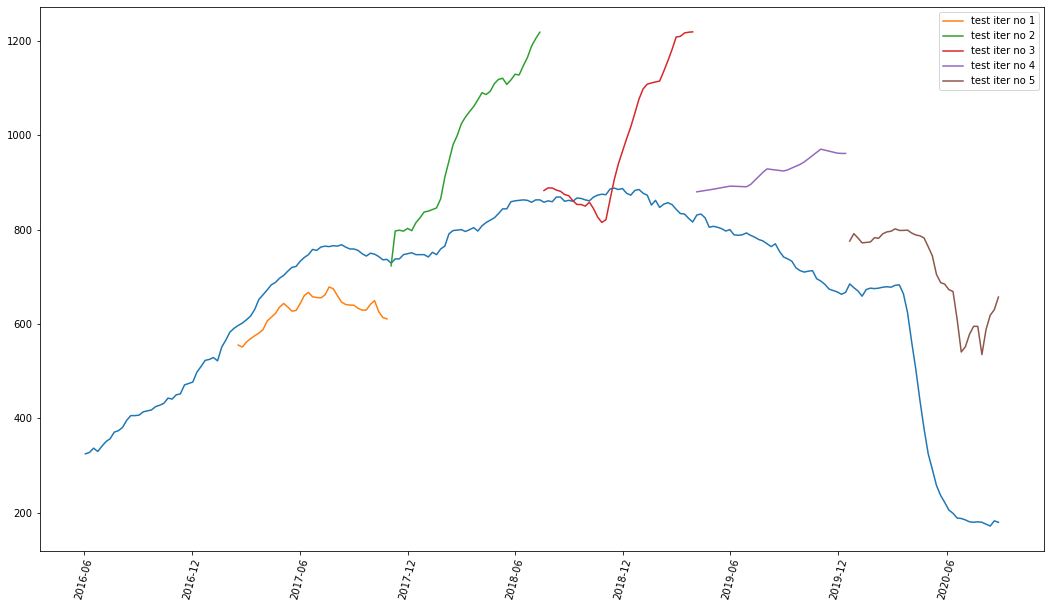

(204.7596591427196, -11.66523432041871, 176.6057200170586)

In [172]:
# Parameter tuning for linear regression - GridSearchCV
feat_sel = SelectKBest(f_regression,k='all')
pipe = make_pipeline(scaler,feat_sel,model)

param_grid = {'selectkbest__k':np.arange(1,X.shape[1]+1)}

gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [173]:
selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
features = pd.Series(coefs, index=X.columns[selected]).sort_values(ascending=False)

print(gs_cv.best_params_)
print(features)

{'selectkbest__k': 2}
wti_spot_lag_14      27.880810
world_cons_smooth    16.714592
dtype: float64


### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

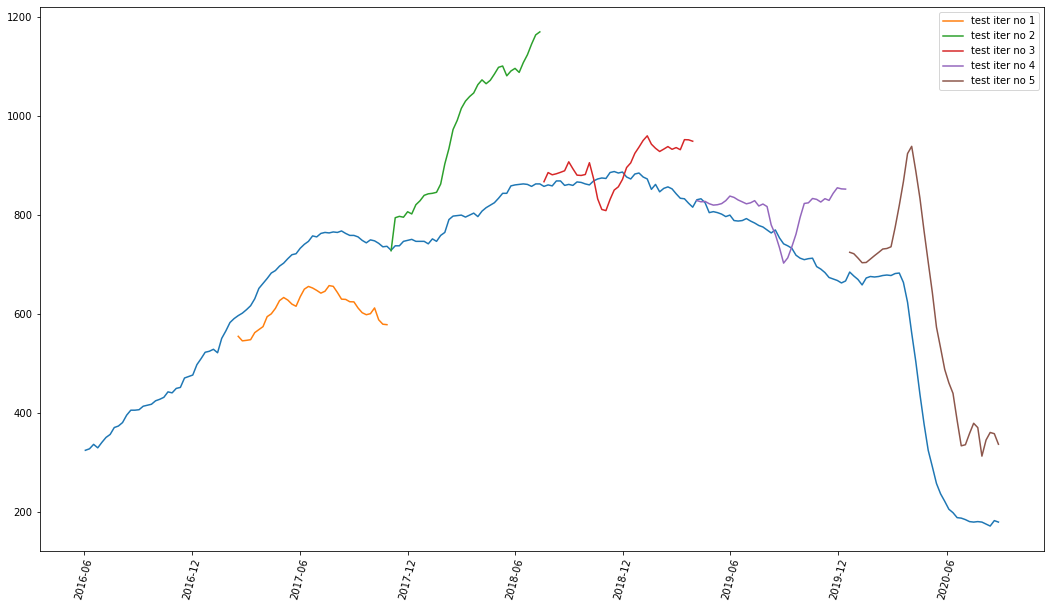

In [174]:
model = Ridge()
pipe = make_pipeline(scaler,model)

ridge_base = plot_model(date,X,y,cv,pipe)

In [175]:
alpha_score = pd.DataFrame(columns=['rmse','r2','mae'])

# Optimised it from 0.005 - 0.5 to 0.001 - 0.01

for i in np.arange(0.001,0.5,step=0.001):
    model = Ridge(alpha=i)
    pipe = make_pipeline(scaler,model)
  
    mse, r2, mae = plot_model(date,X,y,cv,pipe,plot=False)
    
    alpha_score.loc[i,'rmse'] = mse
    alpha_score.loc[i,'r2'] = r2
    alpha_score.loc[i,'mae'] = mae
    
alpha_score.sort_values(by='rmse',inplace=True)
alpha_score.head()

,rmse,r2,mae
0.001,131.187,-9.65172,110.394
0.002,131.277,-9.95232,110.475
0.003,131.368,-10.2288,110.556
0.004,131.46,-10.4802,110.637
0.005,131.551,-10.7064,110.717


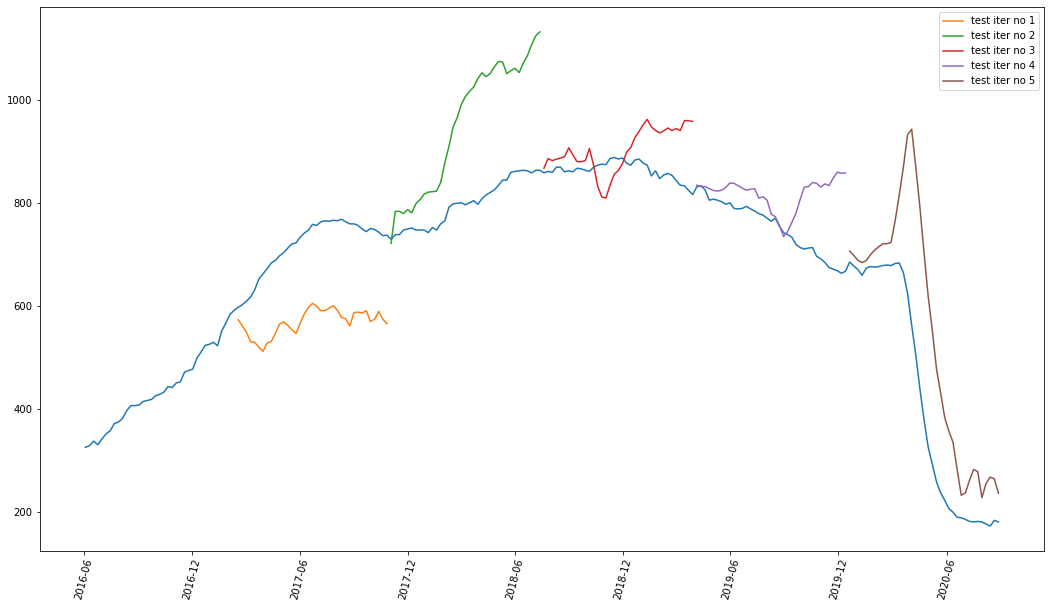

In [176]:
alpha_best = alpha_score.index[0]
model = Ridge(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

ridge_alpha = plot_model(date,X,y,cv,pipe)

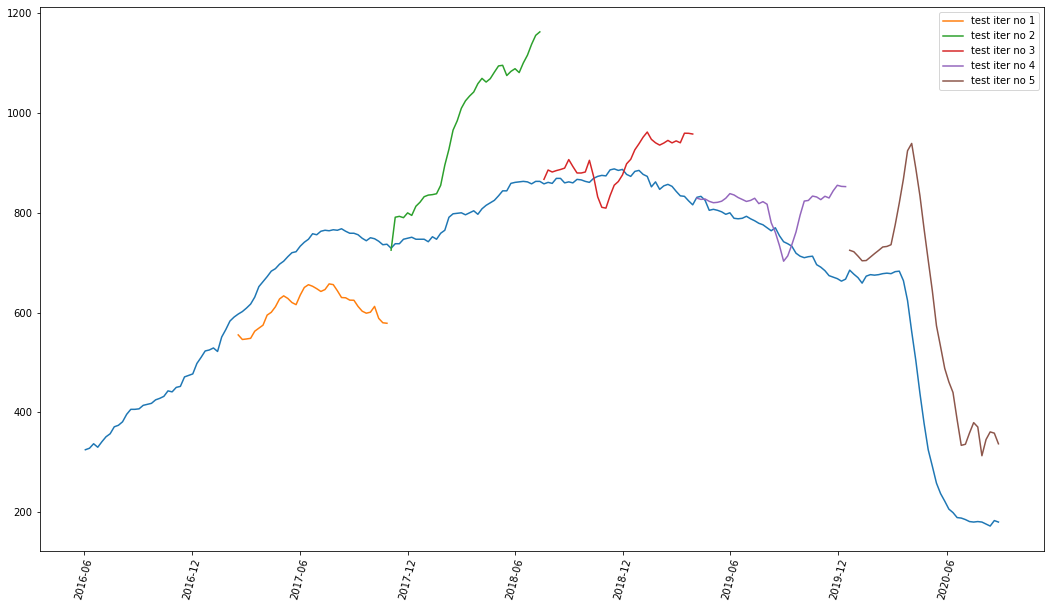

(135.74056265526218, -3.5099939110982574, 116.57566384043915)

In [177]:
param_grid = {'ridge__alpha':np.arange(0.005,1,step=0.005)}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)
plot_model(date,X,y,cv,gs_cv)

In [150]:
print(gs_cv.best_estimator_.named_steps.ridge)

Ridge(alpha=0.495)


In [ ]:
pipe = make_pipeline(scaler,feat_sel,model)

param_grid = {'ridge__alpha':np.arange(0.005,0.5,step=0.005),'selectkbest__k':np.arange(1,len(X.columns)+1)}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.ridge)
print(gs_cv.best_estimator_.named_steps.selectkbest)

### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

In [ ]:
model = Lasso()
pipe = make_pipeline(scaler,feat_sel,model)
param_grid = {'selectkbest__k':np.arange(1,len(X.columns)+1)}

plot_model(date,X,y,cv,model)

In [ ]:
param_grid = {'lasso__alpha':np.arange(0.005,0.5,step=0.005),'selectkbest__k':np.arange(1,len(X.columns)+1)}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.lasso)
print(gs_cv.best_estimator_.named_steps.selectkbest)

### Random Forest Regression 
Baseline model will be a default RF regression

In [ ]:
model = RandomForestRegressor(random_state=42)

pipe = make_pipeline(scaler,model)

plot_model(date,X,y,cv,model)

In [ ]:
param_grid = {
        'randomforestregressor__n_estimators' : np.arange(200,500,step=30)
}

gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [ ]:
print(gs_cv.best_estimator_.named_steps.randomforestregressor)

Historical values of n_estimators (max_train = 150,n_splits=7): 
    np.arange(0,1000,step=100), 300
    np.arange(200,500,step=30), 260
    np.arange(0,500, step = 50), 400
    np.arange(350,500, step = 25), 375

Notes : 
Score does not improve with decrease of max_train